In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys
import config
import os
from matplotlib import rc
import plot_cluster_utils as pcu
import figure_utils 
import warnings
warnings.filterwarnings('ignore')
from scipy.special import gamma
rc('text', usetex=False)
SMALL_SIZE=15
MEDIUM_SIZE=25
rc('legend', fontsize=SMALL_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)
import numpy as np
from numba import jit
from scipy import stats
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
import seaborn as sns
plt.style.use("ggplot")

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
def gamma_afd_prob(x,sigma,K):
    s2_1 = 2/sigma - 1
    s2K = 2/(sigma*K)
    return 1/gamma(s2_1)*(s2K**s2_1)*np.exp(-s2K*x)*(x**(s2_1 -1))

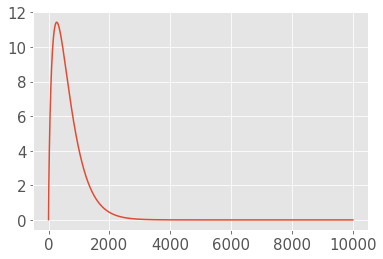

In [98]:
plt.plot(gamma_afd_prob(np.linspace(1e-6,1,10000),sigma,.1))

In [102]:
sum(gamma_afd_prob(np.linspace(1e-6,1,1000000),sigma,.1))/1000000

0.9999999980938942

In [4]:
data_dir = config.data_directory
metadata_dir = config.metadata_directory

rel_ab = pd.read_csv(f"{data_dir}species/relative_abundance.txt.bz2",sep="\t",index_col=0)

In [5]:
tp_matched = pd.read_pickle(f"{metadata_dir}Poyet_host_samples_timepoints.pkl")

In [104]:
def compute_D(species_df):
    
    beta = (species_df["rel_ab"].mean()/species_df["rel_ab"].std())**2
    sigma = 2/(beta+1)
    
    timerange = 50
    K_window_dic = {}
    window_tp_dic = {}

    for i in range(timerange,int(species_df["time"].max())):
        
        species_df_window = species_df.loc[np.logical_and(species_df["time"] >= i - timerange, species_df["time"] < i)]
    
        if species_df_window.shape[0] > 4:
    
            K = species_df_window["rel_ab"].mean()
            K = K/(1-sigma/2)
            K_window_dic[i] = K
            window_tp_dic[i] = species_df_window.index
    
    back_ll = []
    for_ll = []
    key_list = list(window_tp_dic.keys())
    for j in range(len(key_list) - 1):
    
        back_key = key_list[j]
        for_key = key_list[j + 1]
        back_window = species_df.loc[window_tp_dic[back_key]]["rel_ab"].values
        back_ll.append(sum(np.log(gamma_afd_prob(back_window,sigma,K_window_dic[back_key]))))
        for_ll.append(sum(np.log(gamma_afd_prob(back_window,sigma,K_window_dic[for_key]))))

    back_ll = np.array(back_ll)
    for_ll = np.array(for_ll)

    D_plus = for_ll - back_ll
    
    back_ll = []
    for_ll = []
    for j in range(1, len(key_list)):
    
        back_key = key_list[j-1]
        for_key = key_list[j]
        for_window = species_df.loc[window_tp_dic[for_key]]["rel_ab"].values
        back_ll.append(sum(np.log(gamma_afd_prob(for_window,sigma,K_window_dic[back_key]))))
        for_ll.append(sum(np.log(gamma_afd_prob(for_window,sigma,K_window_dic[for_key]))))

    back_ll = np.array(back_ll)
    for_ll = np.array(for_ll)

    D_minus = back_ll - for_ll
    #return(D_minus,D_plus)
    return(np.maximum(np.abs(D_plus[:-1]),np.abs(D_minus[1:])))

In [114]:
host = "am"
mean_abs = rel_ab[tp_matched[host].index].T.mean()
species_list = mean_abs[mean_abs > 1e-2].index 

In [91]:
beta = (species_df["rel_ab"].mean()/species_df["rel_ab"].std())**2
sigma = 2/(beta+1)

NameError: name 'sigma' is not defined

[]

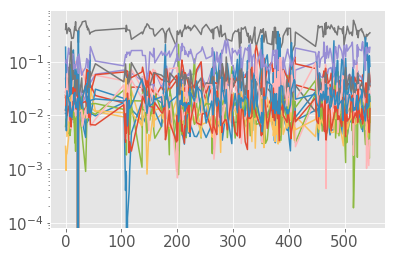

In [85]:
plt.plot(list(tp_matched[host]),rel_ab.loc[species_list,tp_matched[host].index].values.T);
plt.semilogy()

In [298]:
host = "ao"
mean_abs = rel_ab[tp_matched[host].index].T.mean()
species_list = mean_abs[mean_abs > 1e-3].index 
species = species_list[37]
rel_ab_species = rel_ab.loc[species,tp_matched[host].index]
species_df = pd.DataFrame(columns=["rel_ab","time"])
species_df["rel_ab"] = rel_ab_species
species_df["time"] = tp_matched[host]

In [299]:
def compute_D(species_df):

    beta = (species_df["rel_ab"].mean()/species_df["rel_ab"].std())**2
    sigma = 2/(beta+1)
    
    timerange = 50
    K_window_dic = {}
    window_tp_dic = {}

    for i in species_df["time"]:
        
        species_df_window = species_df.loc[np.logical_and(species_df["time"] >= i, species_df["time"] < i+timerange)]
    
        if species_df_window.shape[0] > 4:
    
            K = species_df_window["rel_ab"].mean()
            K = K/(1-sigma/2)
            K_window_dic[i] = K
            window_tp_dic[i] = species_df_window.index
    
    back_ll = []
    for_ll = []
    key_list = list(window_tp_dic.keys())
    for j in range(len(key_list) - 1):
    
        back_key = key_list[j]
        for_key = key_list[j + 1]
        back_window = species_df.loc[window_tp_dic[back_key]]["rel_ab"].values
        back_ll.append(sum(np.log(gamma_afd_prob(back_window,sigma,K_window_dic[back_key]))))
        for_ll.append(sum(np.log(gamma_afd_prob(back_window,sigma,K_window_dic[for_key]))))

    back_ll = np.array(back_ll)
    for_ll = np.array(for_ll)

    D_plus = back_ll - for_ll
    
    back_ll = []
    for_ll = []
    for j in range(1, len(key_list)):
    
        back_key = key_list[j-1]
        for_key = key_list[j]
        for_window = species_df.loc[window_tp_dic[for_key]]["rel_ab"].values
        back_ll.append(sum(np.log(gamma_afd_prob(for_window,sigma,K_window_dic[back_key]))))
        for_ll.append(sum(np.log(gamma_afd_prob(for_window,sigma,K_window_dic[for_key]))))

    back_ll = np.array(back_ll)
    for_ll = np.array(for_ll)

    D_minus = back_ll - for_ll
    
    return(np.maximum(np.abs(D_plus),np.abs(D_minus)))

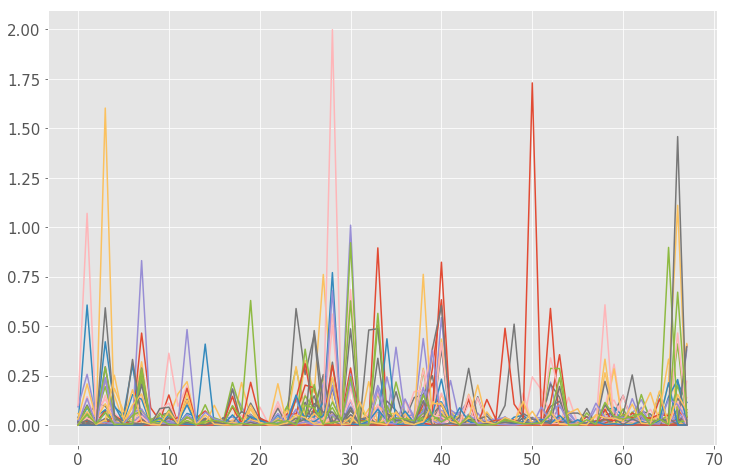

In [300]:
fig,ax = plt.subplots(figsize=(12,8))
for species in species_list:
    
    rel_ab_species = rel_ab.loc[species,tp_matched[host].index]
    species_df = pd.DataFrame(columns=["rel_ab","time"])
    species_df["rel_ab"] = rel_ab_species
    species_df["time"] = tp_matched[host]
    D = np.nan_to_num(compute_D(species_df),0)
    ax.plot(D)
    if max(D) > 4:
        print((species, np.nanmax(D), np.argwhere(D == np.nanmax(D))[0][0]))

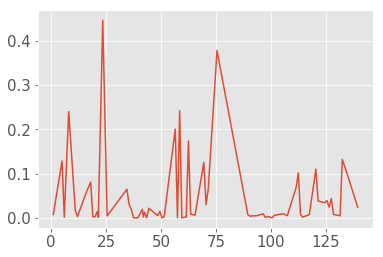

In [243]:
plt.plot(list(window_tp_dic.keys())[1:],D_plus)
#plt.plot(list(window_tp_dic.keys()),D_minus)

In [93]:
beta = (species_df["rel_ab"].mean()/species_df["rel_ab"].std())**2
sigma = 2/(beta+1)

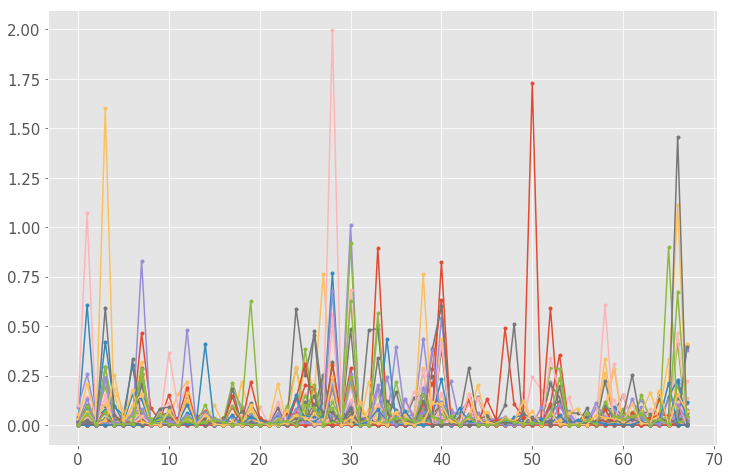

In [285]:
host = "ao"
mean_abs = rel_ab[tp_matched[host].index].T.mean()
species_list = mean_abs[mean_abs > 1e-3].index 

fig,ax = plt.subplots(figsize=(12,8))
for species in species_list:
    
    rel_ab_species = rel_ab.loc[species,tp_matched[host].index]
    species_df = pd.DataFrame(columns=["rel_ab","time"])
    species_df["rel_ab"] = rel_ab_species
    species_df["time"] = tp_matched[host]
    
    D = np.nan_to_num(compute_D(species_df),0)
    ax.plot(D,".-")
    if max(D) > 2:
        print((species, max(D), np.argmax(D)))

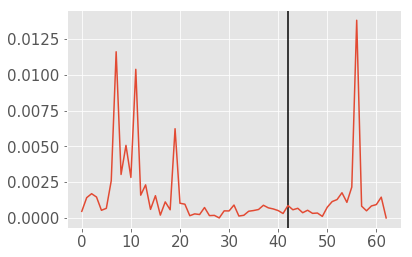

In [281]:
species = 'Faecalibacterium_cf_62236'
rel_ab_species = rel_ab.loc[species,tp_matched[host].index]
plt.plot(list(rel_ab_species))
plt.axvline(42,color="k",zorder=1)
#plt.axvline(130+50,color="k",zorder=1)

#plt.semilogy()

In [282]:
#species = 'Eubacterium_rectale_56927'
out_path = f"{config.analysis_directory}/pi/{species}"
pi = pd.read_csv(f"{out_path}/{species}_pi.txt",index_col=0)

In [283]:
snp_samples = [sample for sample in tp_matched[host].index if sample in pi.index]

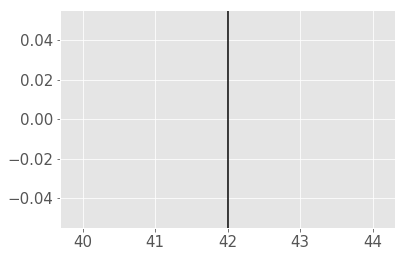

In [284]:
times = tp_matched[host]
plt.plot(list(pi[snp_samples].iloc[0]),"o-")
plt.axvline(42,color="k")
#plt.ylim(1e-3,1e-1)
#plt.semilogy()